In [1]:
# Bibliotecas

import pandas as pd
import numpy as np
import json
from scipy import stats

import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

from datetime import datetime, timezone, timedelta, time, date

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR')
import calendar

from os.path import exists

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()

%load_ext autoreload
%autoreload 2

from Funcoes import Funcoes

## Processamento/Tratamento de Dados

In [2]:
# importar dados

arquivo_csv = 'dados/focos_queimadas.csv'

if not exists(arquivo_csv):
    Funcoes.unir_arquivos()
    
df_focos_queimadas = pd.read_csv(arquivo_csv, sep=',', encoding='latin 1')

### Tratar dados

In [3]:
df_focos_queimadas.drop(['satelite', 'pais'], axis=1, inplace=True)
df_focos_queimadas.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
count,1.367223e+06,1.367223e+06,1.367223e+06,1.368553e+06,1.368553e+06,757417.000000
mean,9.504688e+00,7.087691e-01,-4.706983e+00,-1.031434e+01,-5.207692e+01,62.193874
std,8.999016e+01,2.981452e+00,7.363247e+01,6.385679e+00,7.709857e+00,139.726603
min,-9.990000e+02,0.000000e+00,-9.990000e+02,-3.370900e+01,-7.367366e+01,0.000000
25%,1.000000e+00,0.000000e+00,5.000000e-01,-1.364400e+01,-5.704700e+01,15.000000
50%,5.000000e+00,0.000000e+00,1.000000e+00,-9.390000e+00,-5.101300e+01,28.200000
75%,1.700000e+01,1.000000e-01,1.000000e+00,-6.033000e+00,-4.605900e+01,59.000000
max,8.270000e+02,1.430000e+02,1.000000e+00,5.154000e+00,-3.481600e+01,9612.200000


In [4]:
# diasemchuva, precipitacao, riscofogo

(1330 / df_focos_queimadas.size) * 100

# frp

(611136 / df_focos_queimadas.size) * 100

# Zerando os valores riscofogo, diasemchuva, precipitacao quando vazios

df_focos_queimadas.loc[df_focos_queimadas.diasemchuva.isna(), 'diasemchuva'] = 0
df_focos_queimadas.loc[df_focos_queimadas.precipitacao.isna(), 'precipitacao'] = 0
df_focos_queimadas.loc[df_focos_queimadas.riscofogo.isna(), 'riscofogo'] = 0

# conferindo

df_focos_queimadas.isna().sum()

datahora             0
estado               0
municipio            0
bioma                0
diasemchuva          0
precipitacao         0
riscofogo            0
latitude             0
longitude            0
frp             611136
dtype: int64

In [5]:
with open('dados/estados_map.json', encoding='utf-8') as json_file:
    estados_map = json.load(json_file)

estados_map

{'ACRE': 'AC',
 'ALAGOAS': 'AL',
 'AMAPA': 'AP',
 'AMAZONAS': 'AM',
 'BAHIA': 'BA',
 'CEARA': 'CE',
 'DISTRITO FEDERAL': 'DF',
 'ESPIRITO SANTO': 'ES',
 'GOIAS': 'GO',
 'MARANHAO': 'MA',
 'MATO GROSSO': 'MT',
 'MATO GROSSO DO SUL': 'MS',
 'MINAS GERAIS': 'MG',
 'PARA': 'PA',
 'PARAIBA': 'PB',
 'PARANA': 'PR',
 'PERNAMBUCO': 'PE',
 'PIAUI': 'PI',
 'RIO DE JANEIRO': 'RJ',
 'RIO GRANDE DO NORTE': 'RN',
 'RIO GRANDE DO SUL': 'RS',
 'RONDONIA': 'RO',
 'RORAIMA': 'RR',
 'SERGIPE': 'SE',
 'SANTA CATARINA': 'SC',
 'SAO PAULO': 'SP',
 'TOCANTINS': 'TO'}

In [6]:
df_focos_queimadas = df_focos_queimadas.replace({'estado': estados_map})

In [7]:
# Converter a datahora para um objeto data

df_focos_queimadas['datahora'] = pd.to_datetime(df_focos_queimadas['datahora'], errors='coerce')

# Converter o objeto datahora para o fuso de SP (que é igual o de Brasilia)

df_focos_queimadas['datahora_tz'] = df_focos_queimadas.apply(Funcoes.converter_fuso, axis=1)

In [8]:
# Converter a datahora com fuso de Brasília, para um objeto data

df_focos_queimadas['datahora_tz'] = pd.to_datetime(df_focos_queimadas['datahora_tz'], errors='coerce')

# Separar a data e e hora em colunas diferentes

df_focos_queimadas['data'] = Funcoes.converter_data_hora(df_focos_queimadas, 'datahora_tz', 'data')
df_focos_queimadas['hora'] = Funcoes.converter_data_hora(df_focos_queimadas, 'datahora_tz', 'hora')

df_focos_queimadas['dia_semana'] = df_focos_queimadas['datahora_tz'].dt.weekday # Dia da semana
df_focos_queimadas['mes'] = df_focos_queimadas['datahora_tz'].dt.month # Mês do ano
df_focos_queimadas['ano'] = df_focos_queimadas['datahora_tz'].dt.year # ano

In [9]:
df_focos_queimadas['riscofogo_nivel'] = df_focos_queimadas.apply(Funcoes.classificar_risco_fogo, axis=1)

df_focos_queimadas['riscofogo_categoria'] = df_focos_queimadas.apply(Funcoes.categorizar_risco_fogo, axis=1)

df_focos_queimadas.loc[df_focos_queimadas['diasemchuva'] < 0, ['diasemchuva']] = 0

### Preparação de dados para o modelo

In [10]:
df_focos_queimadas_ml = df_focos_queimadas.copy()

# Excluir colunas que não serão utilizadas

df_focos_queimadas_ml.drop(['datahora', 'datahora_tz', 'data', 'hora', 'latitude', 'longitude', 'municipio', 'estado'], axis=1, inplace=True)

# Transformar os níveis de fogo em ids

df_focos_queimadas_ml['riscofogo_nivel_id'] = labelencoder.fit_transform(df_focos_queimadas_ml['riscofogo_nivel'])

_df1 = pd.get_dummies(df_focos_queimadas_ml['bioma'], prefix="bioma", drop_first=True)
df_focos_queimadas_ml = pd.concat([df_focos_queimadas_ml, _df1], axis=1)

# Excluir colunas não utilizadas

#df_focos_queimadas_ml.drop(['riscofogo_nivel', 'bioma'], axis=1, inplace=True)

df_focos_queimadas_ml.head()

,bioma,diasemchuva,precipitacao,riscofogo,frp,dia_semana,mes,ano,riscofogo_nivel,riscofogo_categoria,riscofogo_nivel_id,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlantica,bioma_Pampa,bioma_Pantanal
0,Amazonia,4.0,0.1,0.6,NaN,5,11,2015,medio,0,3,0,0,0,0,0
1,Cerrado,1.0,0.1,0.3,NaN,3,4,2015,baixo,0,1,0,1,0,0,0
2,Amazonia,3.0,0.4,0.2,NaN,0,3,2015,baixo,0,1,0,0,0,0,0
3,Amazonia,20.0,0.0,1.0,NaN,5,2,2015,critico,1,2,0,0,0,0,0
4,Amazonia,0.0,0.1,0.8,NaN,6,8,2015,alto,1,0,0,0,0,0,0


--- 

## Começar aqui

---

In [93]:
df_focos_queimadas_ml_2 = df_focos_queimadas_ml[
    (df_focos_queimadas_ml['ano'] >= 2018) & (df_focos_queimadas_ml['ano'] <= 2021)
].copy()

In [94]:
len(df_focos_queimadas_ml_2)

737380

In [95]:
df_focos_queimadas_ml_filtered = df_focos_queimadas_ml_2.filter([
    'diasemchuva', 'precipitacao', 'dia_semana', 'mes', 
    'bioma_Caatinga', 'bioma_Cerrado', 'bioma_Mata Atlantica', 'bioma_Pampa', 'bioma_Pantanal',
    'riscofogo_categoria'
])

#df_focos_queimadas_ml_filtered['bioma'] = labelencoder.fit_transform(df_focos_queimadas_ml_filtered['bioma'])
df_focos_queimadas_ml_filtered.head()

,diasemchuva,precipitacao,dia_semana,mes,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlantica,bioma_Pampa,bioma_Pantanal,riscofogo_categoria
608503,0.0,0.0,4,2,0,0,0,0,0,1
608504,0.0,0.0,4,2,0,0,0,0,0,1
608505,0.0,0.1,4,2,0,0,1,0,0,1
608506,0.0,0.3,4,2,1,0,0,0,0,1
608507,0.0,0.0,4,2,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1345878,71.0,0.0,4,8,0,1,0,0,0,1
1345879,21.0,0.0,4,8,0,0,0,0,1,1
1345880,6.0,0.0,4,8,0,0,0,0,0,1
1345881,5.0,0.0,4,8,0,0,1,0,0,1


---

In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tensorflow

from keras.models import Sequential
from keras.layers import Dense, Dropout

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [96]:
features = df_focos_queimadas_ml_filtered.drop(['riscofogo_categoria'], axis = 1)
labels = df_focos_queimadas_ml_filtered['riscofogo_categoria'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.3, random_state = 42)

In [100]:
print('Treino:', len(X_train))
print('Teste:', len(X_test))

Treino: 516166
Teste: 221214


In [97]:
# fitting scaler
sc_features = StandardScaler()

# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)

# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)

# labels
y_test = pd.DataFrame(y_test, columns = ['riscofogo_categoria'])
y_train = pd.DataFrame(y_train, columns = ['riscofogo_categoria'])
X_train.head()

,diasemchuva,precipitacao,dia_semana,mes,bioma_Caatinga,bioma_Cerrado,bioma_Mata Atlantica,bioma_Pampa,bioma_Pantanal
0,2.124121,-0.208126,-1.007647,0.279364,-0.29491,1.484151,-0.312108,-0.081397,-0.246443
1,0.461403,-0.241718,1.015411,-0.680817,-0.29491,-0.673786,-0.312108,-0.081397,-0.246443
2,1.870486,-0.241718,1.521175,-0.200727,-0.29491,1.484151,-0.312108,-0.081397,-0.246443
3,-0.130412,-0.241718,1.015411,0.279364,-0.29491,1.484151,-0.312108,-0.081397,-0.246443
4,-0.637683,0.228575,-0.501882,-2.601177,-0.29491,1.484151,-0.312108,-0.081397,-0.246443


**Step 3: Hyperparameter/ Experiment Results**

In [98]:
model = Sequential()

# input layer + 1st hidden layer
model.add(Dense(6, input_dim=9, activation='relu'))

# 2nd hidden layer
model.add(Dense(6, activation='relu'))

# output layer
model.add(Dense(6, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 6)                 60        
                                                                 
 dense_65 (Dense)            (None, 6)                 42        
                                                                 
 dense_66 (Dense)            (None, 6)                 42        
                                                                 
 dropout_16 (Dropout)        (None, 6)                 0         
                                                                 
 dense_67 (Dense)            (None, 1)                 7         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')

# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 4, epochs = 10)

Epoch 1/10
129042/129042 [==============================] - 272s 2ms/step - loss: 0.4553 - accuracy: 0.8169 - val_loss: 0.4206 - val_accuracy: 0.8250
Epoch 2/10
129042/129042 [==============================] - 247s 2ms/step - loss: 0.4579 - accuracy: 0.8177 - val_loss: 0.4655 - val_accuracy: 0.8247
Epoch 3/10
129042/129042 [==============================] - 233s 2ms/step - loss: 0.4596 - accuracy: 0.8158 - val_loss: 0.4543 - val_accuracy: 0.8236
Epoch 4/10
129042/129042 [==============================] - 232s 2ms/step - loss: 0.4565 - accuracy: 0.8187 - val_loss: 0.4374 - val_accuracy: 0.8241
Epoch 5/10
129042/129042 [==============================] - 240s 2ms/step - loss: 0.4574 - accuracy: 0.8182 - val_loss: 0.4484 - val_accuracy: 0.8282
Epoch 6/10
129042/129042 [==============================] - 246s 2ms/step - loss: 0.4566 - accuracy: 0.8180 - val_loss: 0.4319 - val_accuracy: 0.8248
Epoch 7/10
129042/129042 [==============================] - 231s 2ms/step - loss: 0.4521 - accuracy:

Com 10 épocas = Train: 0.792, Valid: 0.788

Com 50 épocas = Train: 0.799, Valid: 0.795

---

com as mudanças:

Train: 0.830, Valid: 0.829

In [102]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.830, Valid: 0.829


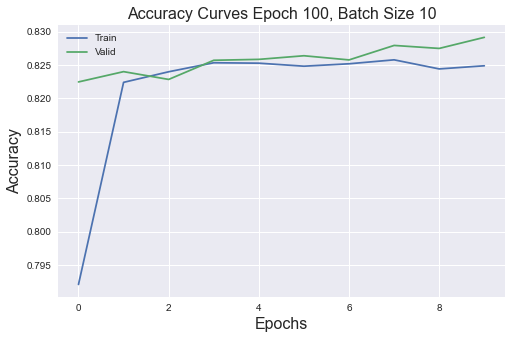

In [103]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')

plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)

plt.show()

In [66]:
# Fit a model and plot learning curve

def fit_model(X_train, y_train, X_test, y_test, n_batch):
    # Define Model
    model = Sequential()
    model.add(Dense(6, input_dim=9, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    
    # Compile Model
    model.compile(optimizer = 'adam',
    metrics=['accuracy'],
    loss = 'binary_crossentropy')
    
    # Fit Model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0, batch_size=n_batch)
    
    # Plot Learning Curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('batch='+str(n_batch))
    plt.legend()

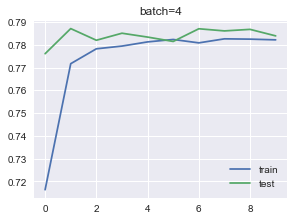

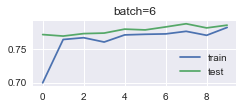

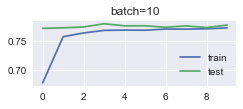

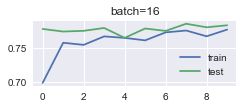

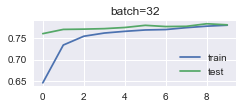

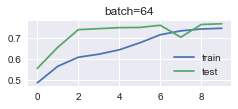

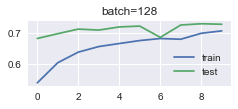

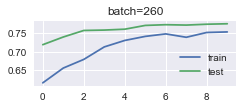

In [67]:
# Create learning curves for different batch sizes
batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
plt.figure(figsize=(10,15))

for i in range(len(batch_sizes)):
    # Determine the Plot Number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)

    # Fit model and plot learning curves for a batch size
    fit_model(X_train, y_train, X_test, y_test, batch_sizes[i])

    # Show learning curves
    plt.show()

In [70]:
def init_model():
    # define model
    model = Sequential()
    model.add(Dense(6, input_dim=4, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    model.compile(optimizer ='adam',
    metrics=['accuracy'],
    loss = 'binary_crossentropy')
    return model

In [71]:
# init model
model = init_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fitting model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0, batch_size=6, callbacks=[es, mc])


Epoch 1: val_accuracy improved from -inf to 0.75058, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.75058 to 0.76993, saving model to best_model.h5

Epoch 3: val_accuracy improved from 0.76993 to 0.78735, saving model to best_model.h5

Epoch 4: val_accuracy did not improve from 0.78735

Epoch 5: val_accuracy improved from 0.78735 to 0.78912, saving model to best_model.h5

Epoch 6: val_accuracy did not improve from 0.78912

Epoch 7: val_accuracy did not improve from 0.78912

Epoch 8: val_accuracy did not improve from 0.78912

Epoch 9: val_accuracy did not improve from 0.78912

Epoch 10: val_accuracy did not improve from 0.78912

Epoch 11: val_accuracy improved from 0.78912 to 0.79168, saving model to best_model.h5

Epoch 12: val_accuracy did not improve from 0.79168

Epoch 13: val_accuracy did not improve from 0.79168

Epoch 14: val_accuracy did not improve from 0.79168

Epoch 15: val_accuracy did not improve from 0.79168

Epoch 16: val_accuracy did not improve fr

KeyboardInterrupt: 